In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
dfStats = gp.read_file("regression_results/ols_run_tdx2.gpkg")
rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

In [3]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,regression.b,regression.b.se,regression.c,regression.c.se,regression.c.year,regression.c.se.year,regression.const,regression.const.se,regression.count,geometry
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,-1.536373e+06,-21292.235597,...,-0.009746,0.002042,7.961810e-08,1.285443e-08,2.510836,0.405377,190.580162,63.669254,106.0,POINT (-1550000 -50000)
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,-1.443186e+06,29895.766148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1450000 50000)
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,-1.440702e+06,459939.024227,...,-0.000209,0.000123,-1.117577e-08,7.446449e-09,-0.352439,0.234831,4.047428,10.607570,2003.0,POINT (-1450000 450000)
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,-1.339945e+06,57970.013154,...,0.000100,0.000029,6.279155e-09,5.980244e-09,0.198019,0.188593,-18.498772,8.515566,2053.0,POINT (-1350000 50000)
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,-1.337447e+06,131513.591615,...,-0.002868,0.000684,-3.380867e-08,2.143677e-08,-1.066190,0.676030,9.540742,32.531749,151.0,POINT (-1350000 150000)


In [4]:
dfStats.shape[0]

258

In [5]:
pd.options.display.float_format = '{:20,.6f}'.format
dfStats.mean()

gridCell.minX                                -61,627.906977
gridCell.minY                               -229,457.364341
gridCell.size                                100,000.000000
statistics.DebrisMaskArea                         37.350430
statistics.GlacierMaskArea                       347.427559
statistics.afterGlacierMask                   10,889.988372
statistics.meanElevationDifference                -9.649519
statistics.pointsWithinDebrisMask                463.620155
statistics.result_avgX                       -11,682.974315
statistics.result_avgY                      -177,651.366345
statistics.result_count_2010                     386.046512
statistics.result_count_2011                   1,244.364341
statistics.result_count_2012                   1,347.259690
statistics.result_count_2013                   1,340.023256
statistics.result_count_2014                   1,299.248062
statistics.result_count_2015                   1,302.461240
statistics.result_count_2016            

<IPython.core.display.Javascript object>


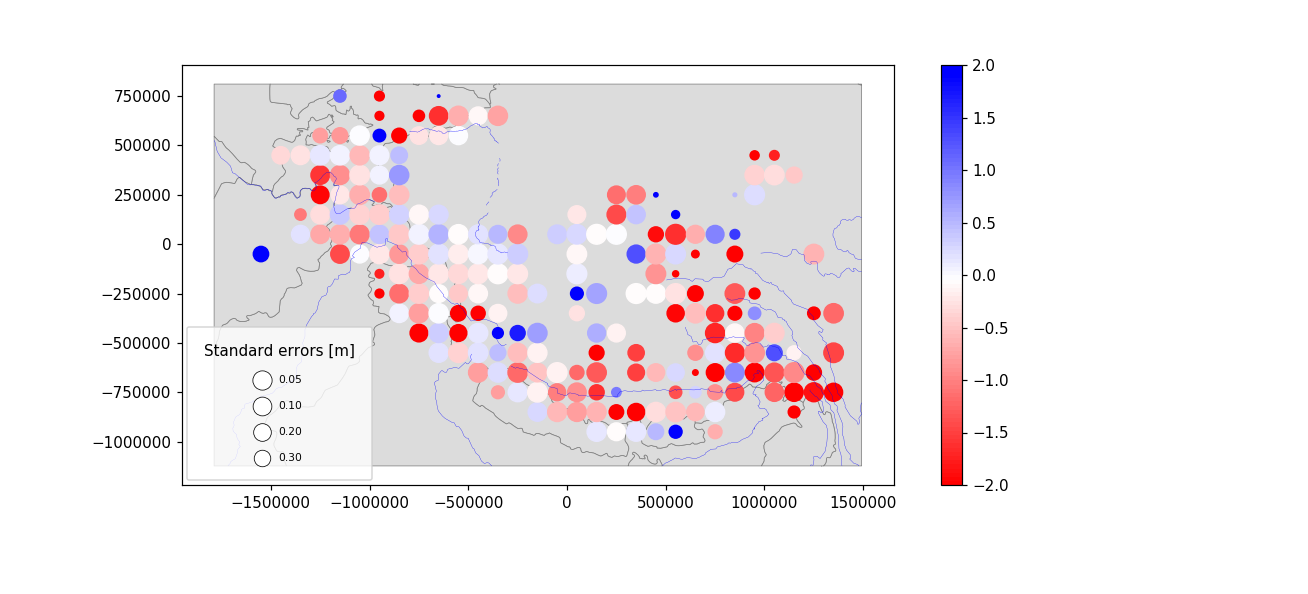

In [4]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors [m]', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
    #print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
    #if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
    #    ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
    #                           (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
    #                           (size/2)+10000), fontsize=5)
#for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
#    print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


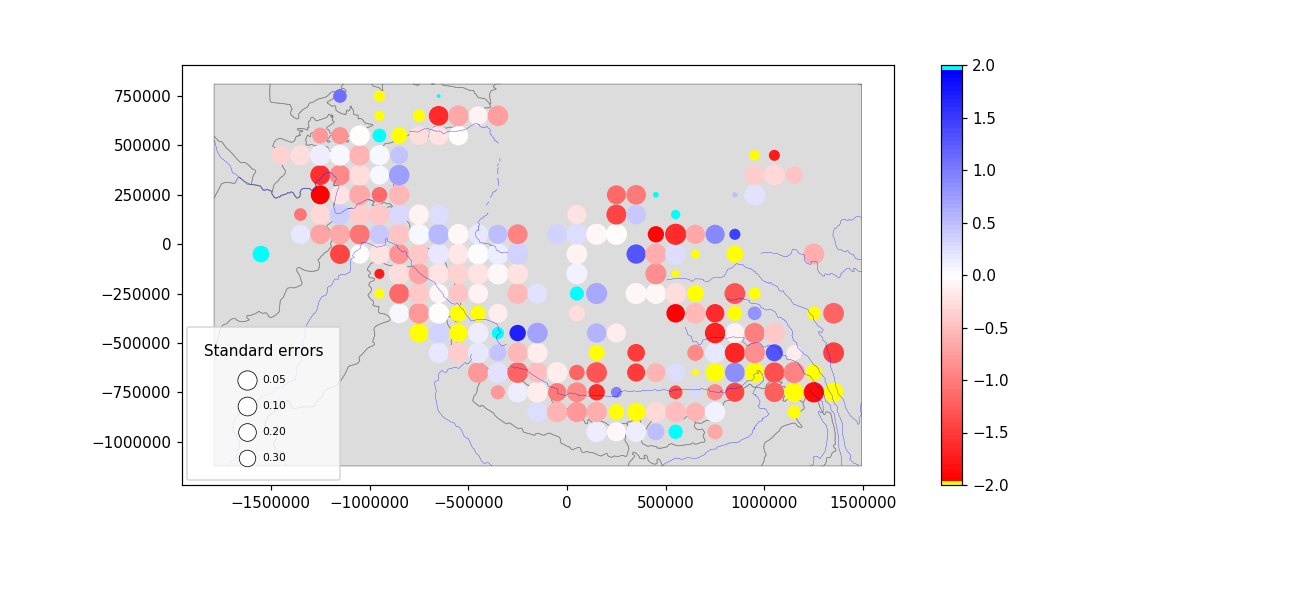

In [8]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',[(1, 1, 0)]+list(map(cm_,range(98)))+[(0, 1, 1)], N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
    #print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
    #if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
    #    ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
    #                           (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
    #                           (size/2)+10000), fontsize=5)
#for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
#    print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


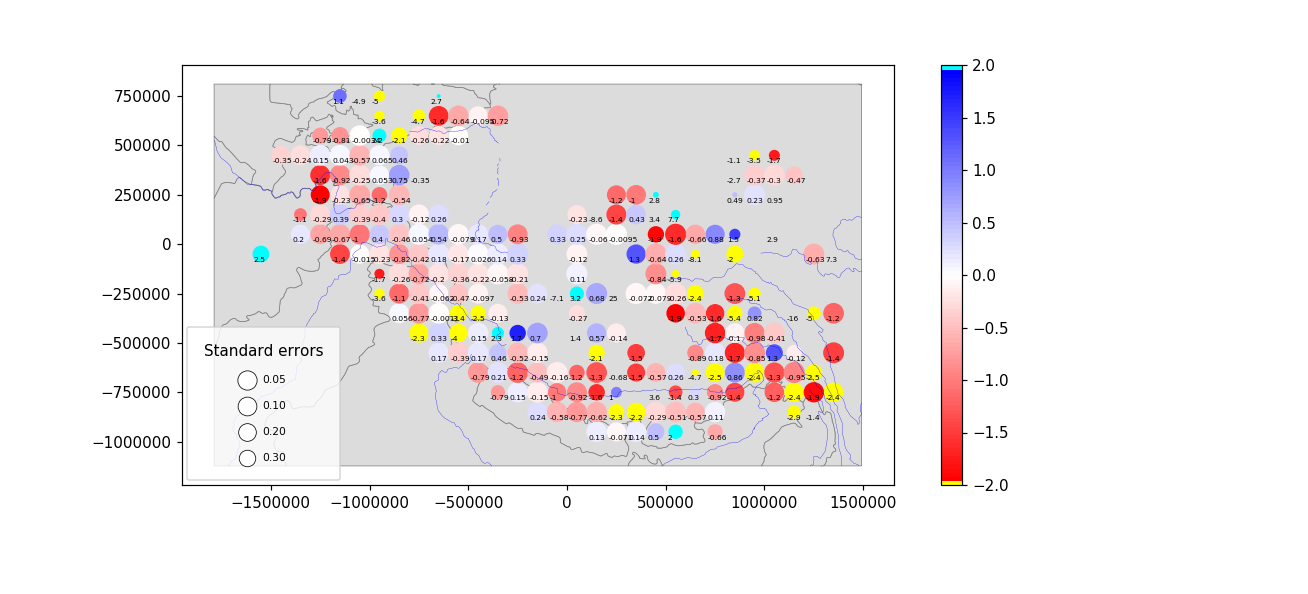

In [5]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',[(1, 1, 0)]+list(map(cm_,range(98)))+[(0, 1, 1)], N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)
for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


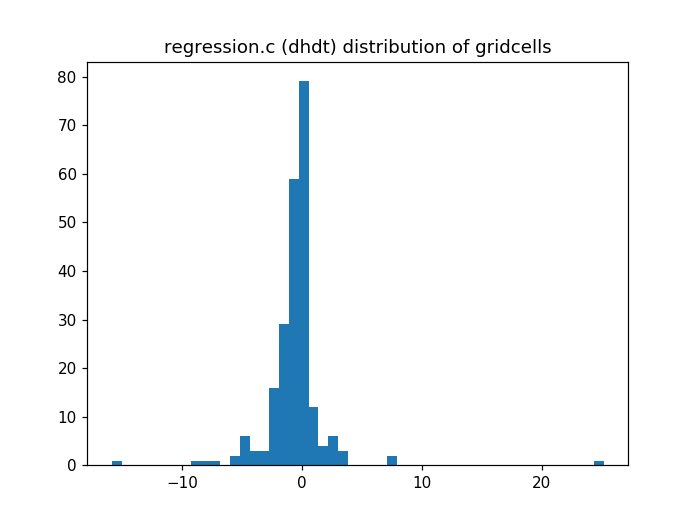

In [16]:
%matplotlib notebook
plt.hist(dfStatsfiltered['regression.c.year'], bins=50)
plt.title('regression.c (dhdt) distribution of gridcells')
plt.show()

<IPython.core.display.Javascript object>


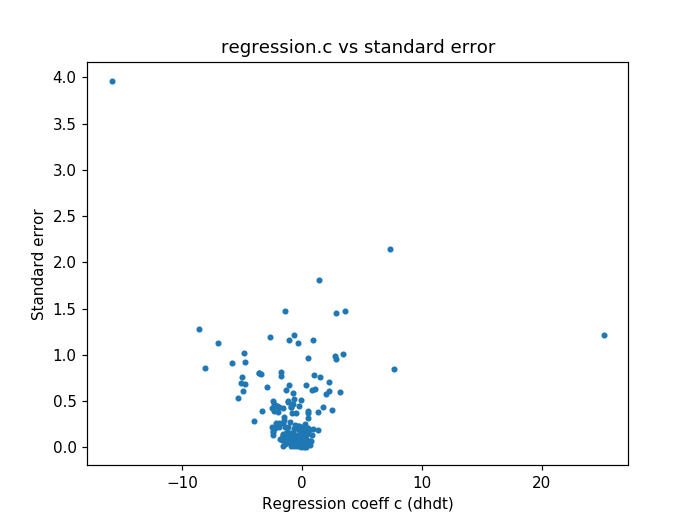

In [17]:
%matplotlib notebook
plt.scatter(dfStatsfiltered['regression.c.year'],dfStatsfiltered['regression.c.se.year'], marker='.')
plt.title('regression.c vs standard error')
plt.xlabel('Regression coeff c (dhdt)')
plt.ylabel('Standard error')
plt.show()

<IPython.core.display.Javascript object>


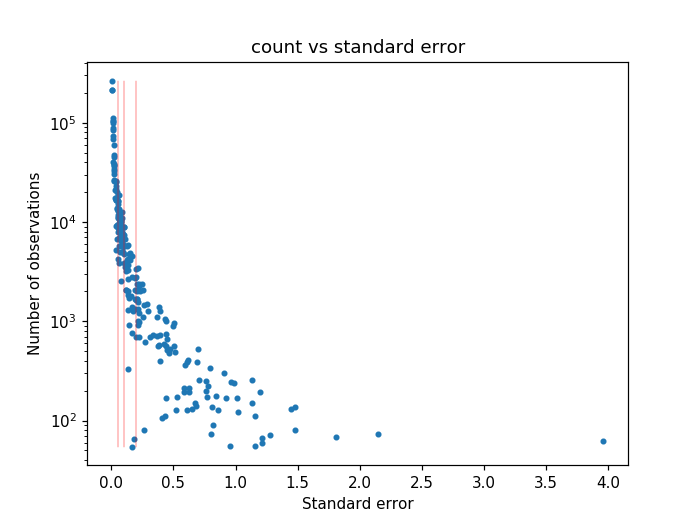

In [18]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.scatter(dfStatsfiltered['regression.c.se.year'],dfStatsfiltered['regression.count'], marker='.')
ymax=dfStatsfiltered['regression.count'].max()
ymin=dfStatsfiltered['regression.count'].min()
plt.plot([0.05,0.05],[ymin,ymax], '-r', linewidth=0.3)
plt.plot([0.1,0.1],[ymin,ymax], '-r', linewidth=0.3)
plt.plot([0.2,0.2],[ymin,ymax], '-r', linewidth=0.3)
plt.title('count vs standard error')
plt.ylabel('Number of observations')
plt.xlabel('Standard error')
ax.set_yscale('log')
plt.show()

<IPython.core.display.Javascript object>


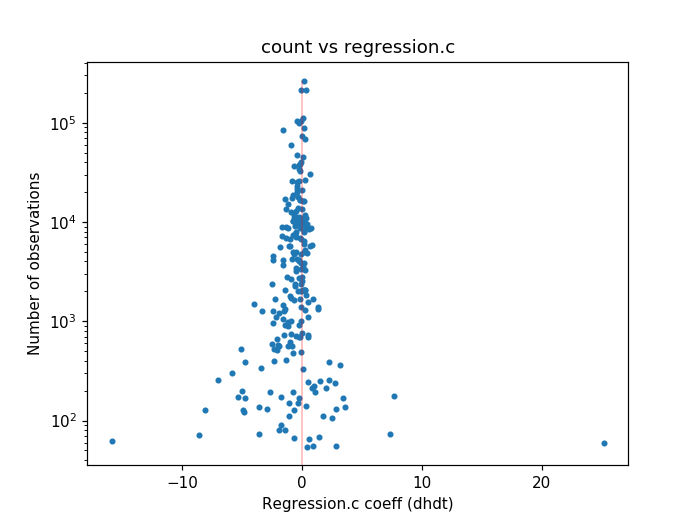

In [19]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.scatter(dfStatsfiltered['regression.c.year'],dfStatsfiltered['regression.count'], marker='.')
ymax=dfStatsfiltered['regression.count'].max()
plt.plot([0,0],[0,ymax], '-r', linewidth=0.3)
plt.title('count vs regression.c')
plt.ylabel('Number of observations')
plt.xlabel('Regression.c coeff (dhdt)')
ax.set_yscale('log')
plt.show()